# Task 2: Dataset Visualization with FiftyOne

## Setup and Imports

In [2]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import fiftyone as fo
from fiftyone import ViewField as F
import fiftyone.utils.random as four

# Check if FiftyOne is available
print(f"FiftyOne version: {fo.__version__}")
print(f"Python version: {os.sys.version}")

FiftyOne version: 1.11.0
Python version: 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]


In [3]:
# Configuration
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data" / "assessment"
DATASET_NAME = "cilp_assessment"
DELETE_EXISTING = True  # Set to False to keep existing dataset

# Verify data path exists
if not DATA_PATH.exists():
    print(f"Warning: Data path {DATA_PATH} does not exist!")
else:
    print(f"Data path: {DATA_PATH}")
    print(f"Available classes: {[d.name for d in DATA_PATH.iterdir() if d.is_dir()]}")

Data path: /sc/home/josef.pribbernow/HPI-Applied-Hands-On-Computer-Vision-2025-Josef-Pribbernow/Assignment-02/data/assessment
Available classes: ['cubes', 'spheres']


In [4]:
# Delete existing dataset if requested
if DELETE_EXISTING and DATASET_NAME in fo.list_datasets():
    print(f"Deleting existing dataset '{DATASET_NAME}'...")
    fo.delete_dataset(DATASET_NAME)
    print("Dataset deleted.")

Deleting existing dataset 'cilp_assessment'...
Dataset deleted.


## 2.1 Grouped Dataset Creation

Create a FiftyOne dataset with group field linking RGB and LiDAR modalities, class labels, and file paths.

In [5]:
# Create FiftyOne dataset with grouped structure
dataset = fo.Dataset(DATASET_NAME, persistent=True)

# Add group field for linking RGB and LiDAR modalities
dataset.add_group_field("group", default="rgb")

In [6]:
# Scan the dataset directory to collect file paths
classes = ["cubes", "spheres"]
samples_data = []

for class_name in classes:
    class_dir = DATA_PATH / class_name
    rgb_dir = class_dir / "rgb"
    lidar_dir = class_dir / "lidar"
    
    rgb_files = sorted(rgb_dir.glob("*.png"))
    
    for rgb_path in tqdm(rgb_files, desc=f"Processing {class_name}"):
        file_id = f"{class_name}_{rgb_path.stem}"
        lidar_path = lidar_dir / f"{rgb_path.stem}.npy"
        
        if lidar_path.exists():
            samples_data.append({
                "rgb_path": str(rgb_path),
                "lidar_path": str(lidar_path),
                "class": class_name,
                "file_id": file_id
            })

print(f"\nTotal samples found: {len(samples_data)}")
print(f"Cubes: {sum(1 for s in samples_data if s['class'] == 'cubes')}")
print(f"Spheres: {sum(1 for s in samples_data if s['class'] == 'spheres')}")

Processing spheres: 100%|██████████| 9999/9999 [00:02<00:00, 3641.38it/s]


Total samples found: 19998
Cubes: 9999
Spheres: 9999


In [7]:
# Create grouped samples (RGB + LiDAR pairs)
# Suppress FiftyOne's progress output to only show tqdm
fo.config.show_progress_bars = False

# Process samples and add to dataset in batches
batch_size = 100
samples_to_add = []

for idx, sample_data in enumerate(tqdm(samples_data, desc="Adding samples to FiftyOne")):
    group = fo.Group()
    
    rgb_sample = fo.Sample(
        filepath=sample_data['rgb_path'],
        group=group.element("rgb")
    )
    rgb_sample["ground_truth"] = fo.Classification(label=sample_data['class'])
    rgb_sample["file_id"] = sample_data['file_id']
    rgb_sample["lidar_path"] = sample_data['lidar_path']
    
    lidar_sample = fo.Sample(
        filepath=sample_data['rgb_path'],
        group=group.element("lidar")
    )
    lidar_sample["ground_truth"] = fo.Classification(label=sample_data['class'])
    lidar_sample["file_id"] = sample_data['file_id']
    lidar_sample["lidar_path"] = sample_data['lidar_path'] 
    lidar_sample["is_lidar"] = True
    
    samples_to_add.extend([rgb_sample, lidar_sample])
    
    if len(samples_to_add) >= batch_size * 2 or idx == len(samples_data) - 1:
        dataset.add_samples(samples_to_add)
        samples_to_add = []

# Re-enable FiftyOne progress bars for future operations
fo.config.show_progress_bars = True

Adding samples to FiftyOne: 100%|██████████| 19998/19998 [00:18<00:00, 1070.64it/s]


In [8]:
SEED = 42

four.random_split(
    dataset,
    {"train": 0.85, "validation": 0.15},
    seed=SEED
)

# Verify split
tag_counts = dataset.count_sample_tags()
print(f"\nSplit complete:")
print(f"Train samples: {tag_counts.get('train', 0)}")
print(f"Validation samples: {tag_counts.get('validation', 0)}")


Split complete:
Train samples: 16998
Validation samples: 3000


## 2.2 Dataset Statistics

Computing and visualizing dataset statistics including class distribution, split sizes, and data characteristics.

In [9]:
dataset.compute_metadata()

Computing metadata...
 100% |█████████████| 39996/39996 [8.9s elapsed, 0s remaining, 5.2K samples/s]       


In [10]:
# Dataset Statistics Summary
print("="*60)
print("CILP ASSESSMENT DATASET STATISTICS")
print("="*60)

# Total samples
print(f"\n1. TOTAL SAMPLES")
print(f"   Total samples: {len(dataset)}")
print(f"   Total groups (RGB+LiDAR pairs): {len(dataset) // 2}")

# Class distribution
print(f"\n2. CLASS DISTRIBUTION")
class_counts = dataset.count_values("ground_truth.label")
for class_name, count in sorted(class_counts.items()):
    percentage = (count / len(dataset)) * 100
    print(f"   {class_name}: {count} samples ({percentage:.1f}%)")

# Train/Validation split
print(f"\n3. TRAIN/VALIDATION SPLIT")
tag_counts = dataset.count_sample_tags()
train_count = tag_counts.get("train", 0)
val_count = tag_counts.get("validation", 0)
print(f"   Train samples: {train_count} ({train_count/len(dataset)*100:.1f}%)")
print(f"   Validation samples: {val_count} ({val_count/len(dataset)*100:.1f}%)")

# Train split by class
train_view = dataset.match_tags("train")
train_class_counts = train_view.count_values("ground_truth.label")
print(f"\n   Train split by class:")
for class_name, count in sorted(train_class_counts.items()):
    print(f"     {class_name}: {count} samples")

# Validation split by class
val_view = dataset.match_tags("validation")
val_class_counts = val_view.count_values("ground_truth.label")
print(f"\n   Validation split by class:")
for class_name, count in sorted(val_class_counts.items()):
    print(f"     {class_name}: {count} samples")

# Image dimensions and types
print(f"\n4. IMAGE CHARACTERISTICS")
sample = dataset.first()
print(f"   Image dimensions: {sample.metadata.width} x {sample.metadata.height}")
print(f"   MIME type: {sample.metadata.mime_type}")
print(f"   Number of channels: {sample.metadata.num_channels}")

CILP ASSESSMENT DATASET STATISTICS

1. TOTAL SAMPLES
   Total samples: 19998
   Total groups (RGB+LiDAR pairs): 9999

2. CLASS DISTRIBUTION
   cubes: 9999 samples (50.0%)
   spheres: 9999 samples (50.0%)

3. TRAIN/VALIDATION SPLIT
   Train samples: 16998 (85.0%)
   Validation samples: 3000 (15.0%)

   Train split by class:
     cubes: 8521 samples
     spheres: 8477 samples

   Validation split by class:
     cubes: 1478 samples
     spheres: 1522 samples

4. IMAGE CHARACTERISTICS
   Image dimensions: 64 x 64
   MIME type: image/png
   Number of channels: 4


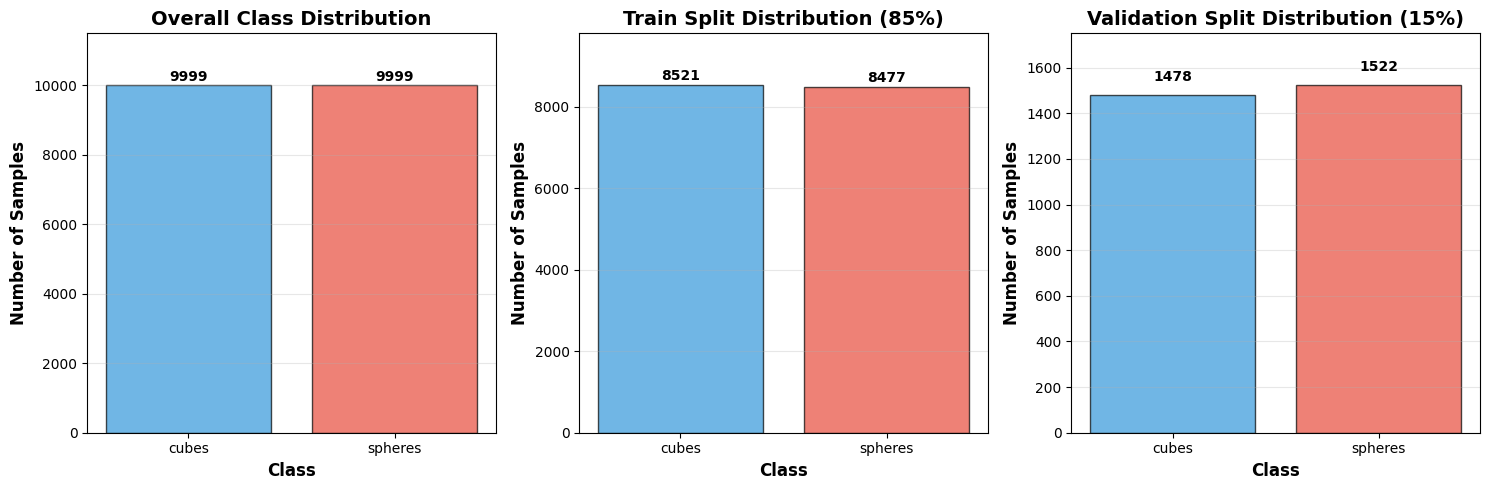

Class distribution visualization saved as 'cilp_dataset_statistics.png'


In [11]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Overall class distribution
ax1 = axes[0]
classes = list(class_counts.keys())
counts = list(class_counts.values())
colors = ['#3498db', '#e74c3c']
ax1.bar(classes, counts, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(counts) * 1.15)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(counts):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Train split distribution
ax2 = axes[1]
train_classes = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
ax2.bar(train_classes, train_counts, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Train Split Distribution (85%)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(train_counts) * 1.15)
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts):
    ax2.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Validation split distribution
ax3 = axes[2]
val_classes = list(val_class_counts.keys())
val_counts = list(val_class_counts.values())
ax3.bar(val_classes, val_counts, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax3.set_title('Validation Split Distribution (15%)', fontsize=14, fontweight='bold')
ax3.set_ylim(0, max(val_counts) * 1.15)
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(val_counts):
    ax3.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('01_dataset_exploration_cilp_dataset_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Class distribution visualization saved as 'cilp_dataset_statistics.png'")

## 2.3 Visual Exploration

Launch FiftyOne App to explore RGB and LiDAR data side-by-side, and document observations.

In [12]:
session = fo.launch_app(dataset, port=5151, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.

Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.11.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|




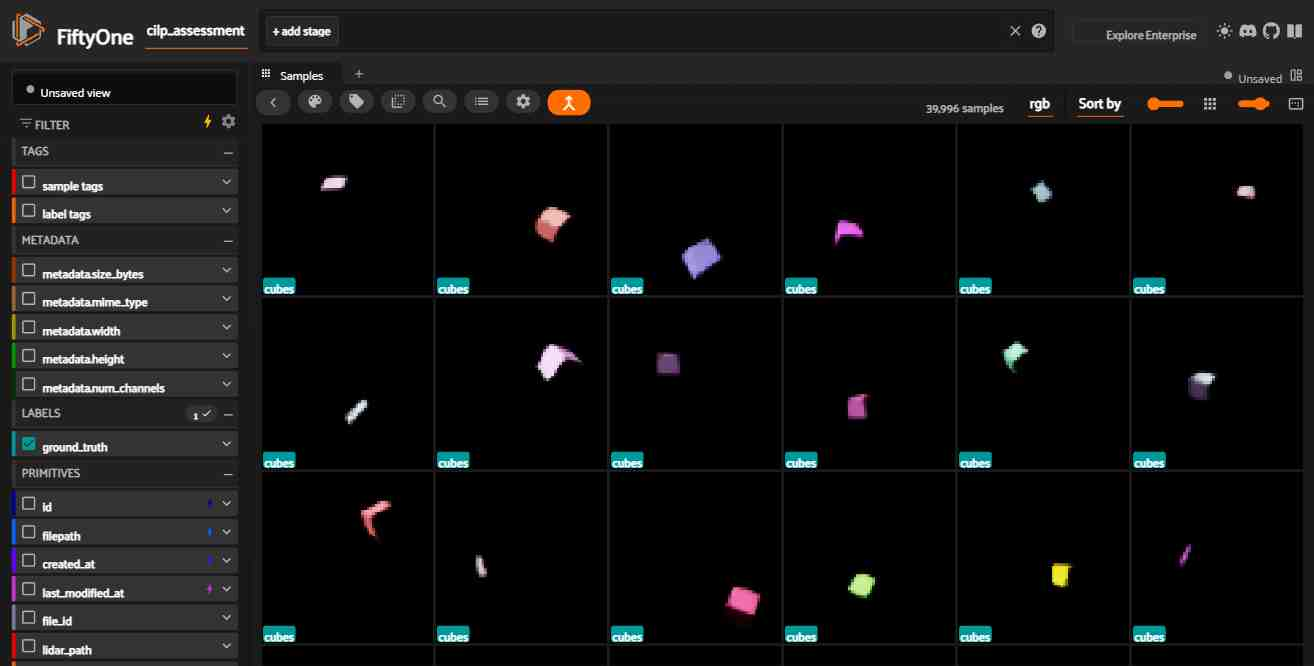

In [13]:
session.show()

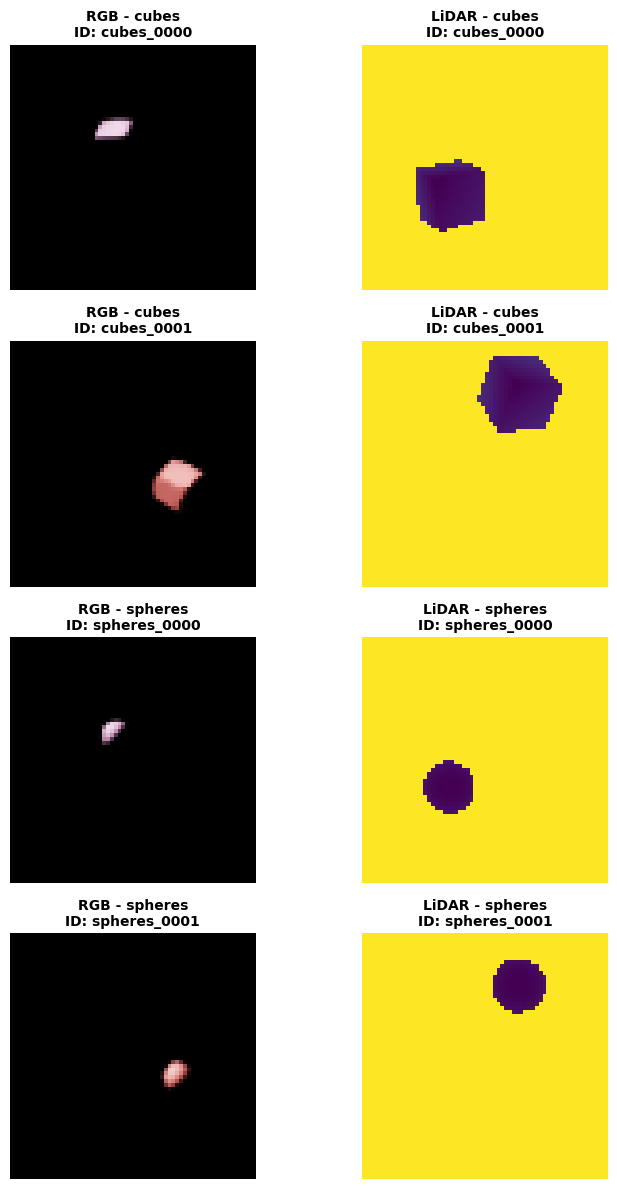

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12))

# Get a few samples from each class (RGB only)
cubes_view = dataset.match(F("ground_truth.label") == "cubes").match(F("group.name") == "rgb").limit(2)
spheres_view = dataset.match(F("ground_truth.label") == "spheres").match(F("group.name") == "rgb").limit(2)

sample_pairs = []
for sample in cubes_view:
    sample_pairs.append(sample)
for sample in spheres_view:
    sample_pairs.append(sample)

row = 0
for rgb_sample in sample_pairs:    
    rgb_img = Image.open(rgb_sample.filepath)
    
    lidar_data = np.load(rgb_sample["lidar_path"])
        
    lidar_min, lidar_max = lidar_data.min(), lidar_data.max()
    if lidar_max > lidar_min:
        lidar_normalized = (lidar_data - lidar_min) / (lidar_max - lidar_min)
    else:
        lidar_normalized = np.zeros_like(lidar_data)
    
    axes[row, 0].imshow(rgb_img)
    axes[row, 0].set_title(f"RGB - {rgb_sample.ground_truth.label}\nID: {rgb_sample['file_id']}", fontweight='bold', fontsize=10)
    axes[row, 0].axis('off')
    
    axes[row, 1].imshow(lidar_normalized, cmap='viridis')
    axes[row, 1].set_title(f"LiDAR - {rgb_sample.ground_truth.label}\nID: {rgb_sample['file_id']}", fontweight='bold', fontsize=10)
    axes[row, 1].axis('off')
    
    row += 1

for i in range(row, 4):
    for j in range(2):
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('01_dataset_exploration_rgb_lidar_sample_pairs.png', dpi=300, bbox_inches='tight')
plt.show()